![INSA](https://www.insa-lyon.fr/sites/all/themes/insa/logo.png)

# GI-5-DSC - Data Science: Decision trees
***


In this notebook we will go deeper in decision trees, discussing how to train, visualize, and make predictions. 
Then we will go through the CART training algorithm used by Scikit-Learn, and we will discuss how to regularize trees and use them for regression tasks. Finally, we will discuss some of the limitations of Decision Trees.

For the experiments we will use a [dataset of supply chains](https://data.mendeley.com/datasets/8gx2fvg2k6/5) from the DataCo Global company.
The dataset used in this tutorial is maintained transparently with the Creative Commons 4.0 license by Fabian Constante, Fernando Silva, and António Pereira through the Mendeley data repository. It consists of roughly 180k transactions from supply chains used by the company DataCo Global for 3 years (from 2015 to 2018).

The `DataCoSupplyChainDataset.csv` file can be downloaded from Moodle.


## 1. Set up the Environment

### 1.1. Importing all required libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

# decision tree visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
from six import StringIO 
import pydotplus
from matplotlib.colors import ListedColormap

## hiding the warnings
import warnings
warnings.filterwarnings('ignore') 

path = "./data/"

* Download the dataset:

In [ ]:
! wget https://github.com/ludovicmoncla/insa-5gi-dsc-tutorials/raw/refs/heads/main/data/DataCoSupplyChainDataset.csv

path = ''

### 1.2. Import data and take a first look at it


Use the [read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) method from the Pandas library to load the `DataCoSupplyChainDataset.csv` file into a dataframe. 

Hint: you need to use the `encoding='unicode_escape'` param for this dataset.


In [ ]:
## Importing Dataset using pandas
data = pd.read_csv(path + "DataCoSupplyChainDataset.csv", encoding='unicode_escape')

data.head() # Checking 5 rows in dataset

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

## 2. Data exploration

This dataset will be used to train models to predict suspected fraud transactions. The feature `'Order Status'` will be used as label.

* Display the list of unique values for the `'Order Status'` feature:

In [5]:
data['Order Status'].unique().tolist()

['COMPLETE',
 'PENDING',
 'CLOSED',
 'PENDING_PAYMENT',
 'CANCELED',
 'PROCESSING',
 'SUSPECTED_FRAUD',
 'ON_HOLD',
 'PAYMENT_REVIEW']

First, we want to plot the data and display the pairwise relationships in this dataset between some of the features and the labels. 
For visualization purpose, we will select only 4 features (in addition to the label).

* Select only 4 features from the dataset:

In [6]:
columns = ['Benefit per order', 'Sales per customer', 'Product Price', 'Type', 'Order Status']

df = data[columns]
df.head()

,Benefit per order,Sales per customer,Product Price,Type,Order Status
0,91.250000,314.640015,327.75,DEBIT,COMPLETE
1,-249.089996,311.359985,327.75,TRANSFER,PENDING
2,-247.779999,309.720001,327.75,CASH,CLOSED
3,22.860001,304.809998,327.75,DEBIT,COMPLETE
4,134.210007,298.250000,327.75,PAYMENT,PENDING_PAYMENT


We notice that `'Type'` is a categorical feature, so we have to encode it as a numerical feature. We use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html): 

In [7]:
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])

df.head()

,Benefit per order,Sales per customer,Product Price,Type,Order Status
0,91.250000,314.640015,327.75,1,COMPLETE
1,-249.089996,311.359985,327.75,3,PENDING
2,-247.779999,309.720001,327.75,0,CLOSED
3,22.860001,304.809998,327.75,1,COMPLETE
4,134.210007,298.250000,327.75,2,PENDING_PAYMENT


We can now use the [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function available in the `seaborn library`. This function will create a grid of Axes such that each numeric variable in data will by shared across the y-axes across a single row and the x-axes across a single column. The diagonal plots are treated differently: a univariate distribution plot is drawn to show the marginal distribution of the data in each column.

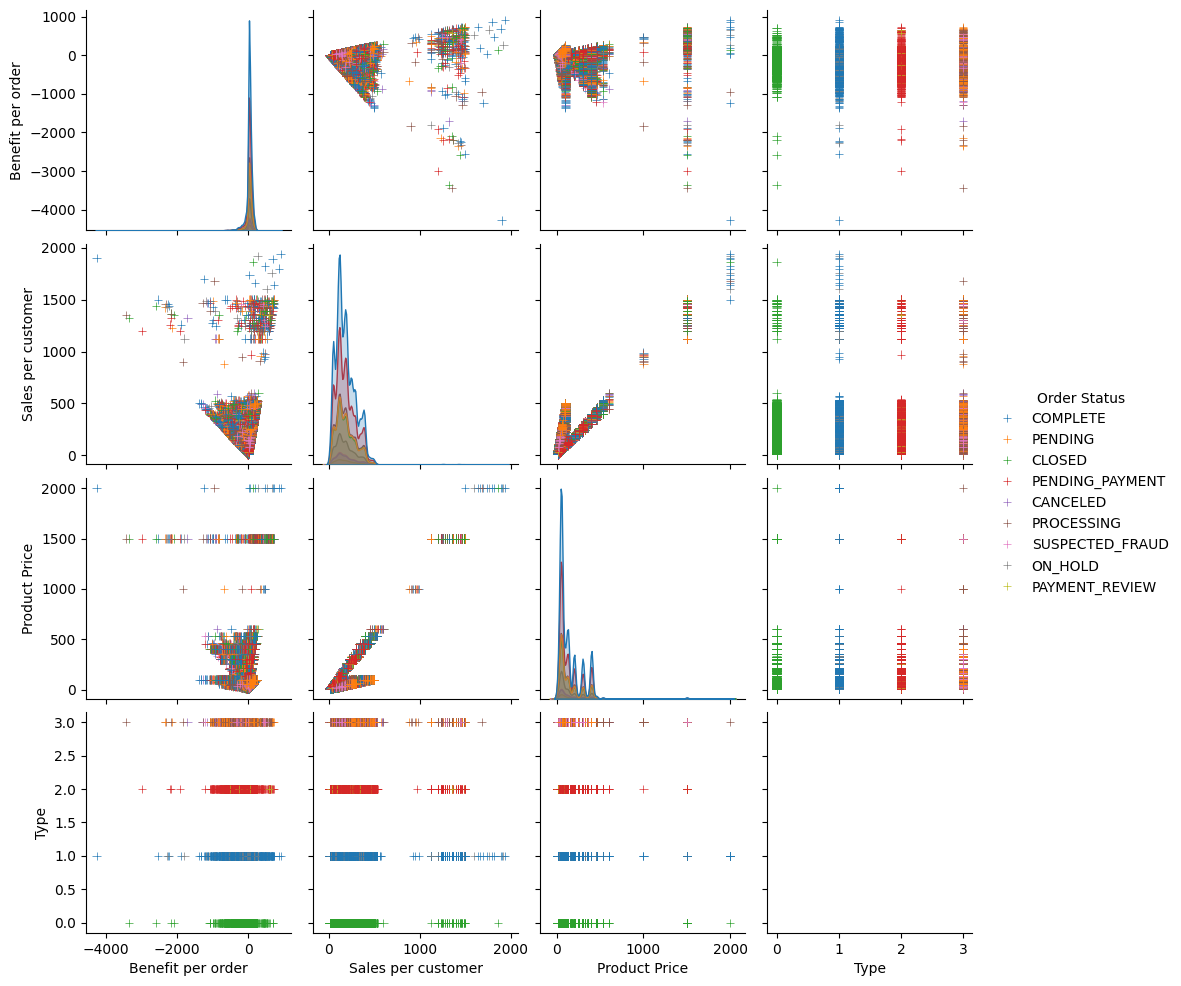

In [8]:
g = sns.pairplot(df, hue='Order Status', diag_kind="kde", markers="+")

# if nothing appears, run this cell twice

The result is not easy to read. Let's simplify and reduce the number of colors, thus the number of possible values for the `'Order Status'`. 
As we are interested by predicting fraud, we assume that the status can take only two values `'suspected_fraud'` and `'other'`.

In [9]:
df['Order Status'] = np.where(df['Order Status'] == 'SUSPECTED_FRAUD', 'SUSPECTED_FRAUD', 'Other')

In [ ]:
g = sns.pairplot(df, hue='Order Status', diag_kind="kde", markers="+")

Now it is a bit more easy to analyse and make some hypothesis. 

What can you deduce from these diagrams?

## 3. Training a Decision Tree

Let's see what is a Decision Tree with an example. Using this dataset, we'll train a Decision Tree for predicting the `'Order Status'` of the transactions based on the 4 features previously selected.
This is a supervised classification problem (`SUSPECTED_FRAUD` vs. `Other`). We'll use the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) class from the scikit-learn library.


In [10]:
class_names = df['Order Status'].unique()
class_names

array(['Other', 'SUSPECTED_FRAUD'], dtype=object)

* We start with a tree limited with `max_deph` = 3:

In [11]:
columns = ['Benefit per order', 'Sales per customer', 'Product Price', 'Type']

X = df[columns]             # input data for training
y = df['Order Status']      # output data to predict

# declare the classifier, choose max_depth = 3
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=21)

#train the classifier
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=21)

* Display the Decision Tree:

[Graphviz](https://graphviz.org) needs to be installed.

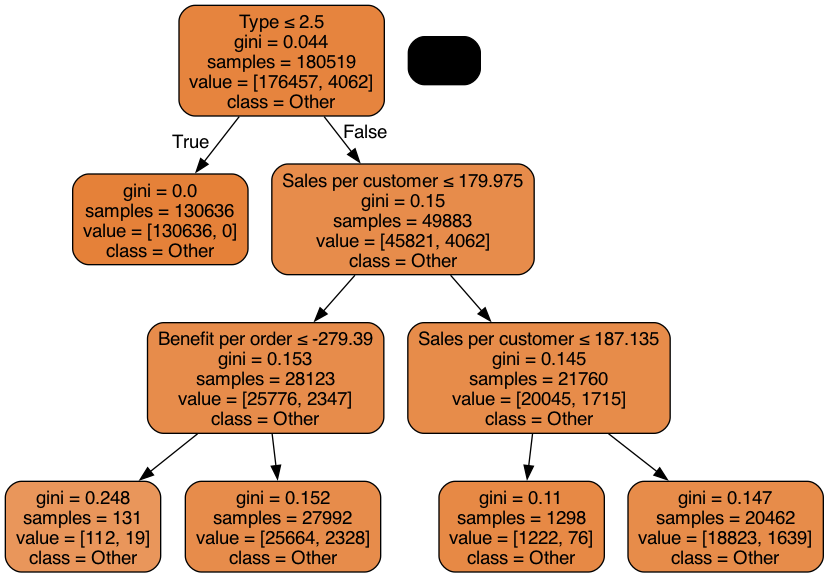

In [12]:
dot_data = StringIO()

export_graphviz(tree_clf, 
                out_file = dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True,
                feature_names = columns,
                class_names = class_names
               )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

What do you understand? Can you explain what is a Decision Tree and how we can use it for predicting classes?

Let's change some values to see what appens with the tree. For instance, we will remove all the data having the feature `'Sales per customer'` >= 187.135 and `'Order Status'` == 'Other'.

What's going to happen? What will this change?

In [13]:
df_dropped = df.drop(df.loc[(df['Sales per customer']>= 187.135) & (df['Order Status'] == 'Other')].index)

In [14]:
X = df_dropped[columns]   
y = df_dropped['Order Status']    

# declare the classifier, choose max_depth = 3
tree_clf_dropped = DecisionTreeClassifier(max_depth=3, random_state=21)

#train the classifier
tree_clf_dropped.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=21)

* Display the Decision Tree:

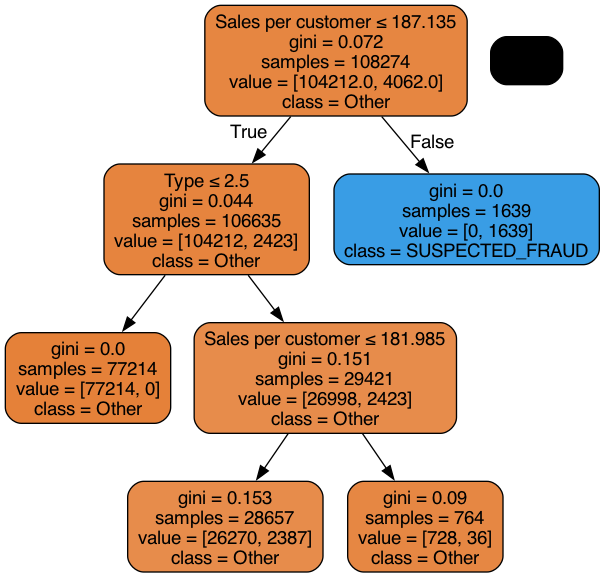

In [15]:
dot_data = StringIO()

export_graphviz(tree_clf_dropped, 
                out_file = dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True,
                feature_names = columns,
                class_names = class_names
               )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Now let's train a Decision Tree without setting the max_deph. 

What do you think this will produce?

In [ ]:
X = df[columns]   
y = df['Order Status']   

# delcare the classifier, no max_deph
tree_clf = DecisionTreeClassifier(random_state=21)

#train the classifier
tree_clf.fit(X, y)

* Display the Decision Tree:

In [ ]:
dot_data = StringIO()

export_graphviz(tree_clf, 
                out_file=dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True,
                feature_names = columns,
                class_names = class_names
               )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 4. Predicting classes and class probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular class k: first it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node. For example, suppose you have a new trasaction and wanted to know if this transaction might be a fraud. 


In [16]:
# values: ['Benefit per order', 'Sales per customer', 'Product Price', 'Type']

new_transaction = [55 , 134, 799, 1]
new_transaction2 = [75, 200, 155, 3]
new_transaction3 = [82, 167, 143, 3]

Using the visualisation of the `tree_clf_dropped` Decision Tree can you guess is these trasactions are suspected fraud?

Let's verify:

In [17]:
tree_clf_dropped.predict_proba([new_transaction])

array([[1., 0.]])

In [18]:
tree_clf_dropped.predict_proba([new_transaction2])

array([[0., 1.]])

In [19]:
tree_clf_dropped.predict_proba([new_transaction3])

array([[0.91670447, 0.08329553]])

In [20]:
tree_clf_dropped.predict([new_transaction])

array(['Other'], dtype=object)

In [21]:
tree_clf_dropped.predict([new_transaction2])

array(['SUSPECTED_FRAUD'], dtype=object)

In [22]:
tree_clf_dropped.predict([new_transaction3])

array(['Other'], dtype=object)

## 5. The CART Training Algorithm

Scikit-Learn uses the Classification And Regression Tree (CART) algorithm to train Decision Trees (also called “growing” trees). The idea is really quite simple: the algorithm first splits the training set in two subsets using a single feature k and a threshold $t_k$ (e.g., “petal length ≤ 2.45 cm”). 

How does it choose k and $t_k$? 

It searches for the pair (k, $t_k$) that produces the purest subsets (weighted by their size). The cost function that the algorithm tries to minimize is given by the following equation:

$$J(k,t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right}$$
where $G_{left/right}$ measures the impurity of the left/right subset and $m_{left/right}$ is the number of instances in the left/right subset.

Once it has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity. A few other hyperparameters control additional stopping conditions (min_samples_split, min_samples_leaf, min_weight_fraction_leaf, and max_leaf_nodes)

Unfortunately, finding the optimal tree is known to be an NP-Complete problem: it requires 
$O(exp(m))$ time, making the problem intractable even for fairly small training sets. This is why we must settle for a “reasonably good” solution.

## 6. Gini impurity or Entropy?

By default, the Gini impurity measure is used, but you can select the entropy impurity measure instead by setting the criterion hyperparameter to "entropy". The concept of entropy originated in thermodynamics as a measure of molecular disorder: entropy approaches zero when molecules are still and well ordered. It later spread to a wide variety of domains, including Shannon’s information theory, where it measures the average information content of a message:
entropy is zero when all messages are identical. 
In Machine Learning, it is frequently used as an impurity measure: a set’s entropy is zero when it contains instances of only one class. 
The following equation shows the definition of the entropy of the $i_{th}$ node.
For example, the depth-2 left node in the previous figure has an entropy equal to $-\frac{49}{54}log(\frac{49}{54})-\frac{5}{54}log(\frac{5}{54}) \approx 0.31$

$$H_i = -\sum_{k=1 p_{i,k}\neq 0}p_{i,k} log(p{i,k})$$

So should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.


## 7. Regularization hyperparameters

Decision Trees make very few assumptions about the training data (as opposed to linear models, which obviously assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, and most likely overfitting it. Such a model is often called a nonparametric model, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a parametric model such as a linear model has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training (this is called regularization). The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decision Tree. In Scikit-Learn, this is controlled by the `max_depth` hyperparameter (the default value is None, which means unlimited). Reducing `max_dept` will regularize the model and thus reduce the risk of overfitting.

The `DecisionTreeClassifier` class has a few other parameters that similarly restrict the shape of the Decision Tree: `min_samples_split` (the minimum number of samples a node must have before it can be split), `min_samples_leaf` (the minimum number of samples a leaf node must have), `min_weight_fraction_leaf` (same as min_samples_leaf but expressed as a fraction of the total number of weighted instances), `max_leaf_nodes` (maximum number of leaf nodes), and max_features (maximum number of features that are evaluated for splitting at each node). Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model.

## 8. Decision Tree for regression

Decision Trees are also capable of performing regression tasks. Let’s build a regression tree using Scikit-Learn’s `DecisionTreeRegressor` class, training it on a noisy quadratic dataset with `max_depth=2`:


In [23]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
Xreg = np.random.rand(m, 1)
yreg = 4 * (Xreg - 0.5) ** 2
yreg = yreg + np.random.randn(m, 1) / 10

* Plot the points:

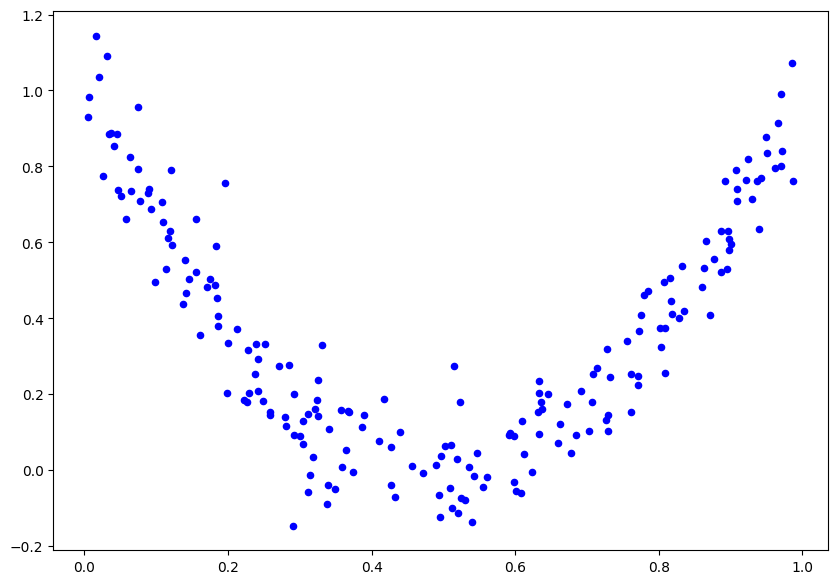

In [24]:
fig, ax = plt.subplots(1,1, figsize =(10,7))
ax.scatter(Xreg, yreg, c="blue", s=20)

* Now build the regression tree using Scikit-Learn’s [DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) class with `max_depth=2`:

In [25]:
# Declare the classifier
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=21)
# Train the classifier
tree_reg.fit(Xreg, yreg)


DecisionTreeRegressor(max_depth=2, random_state=21)

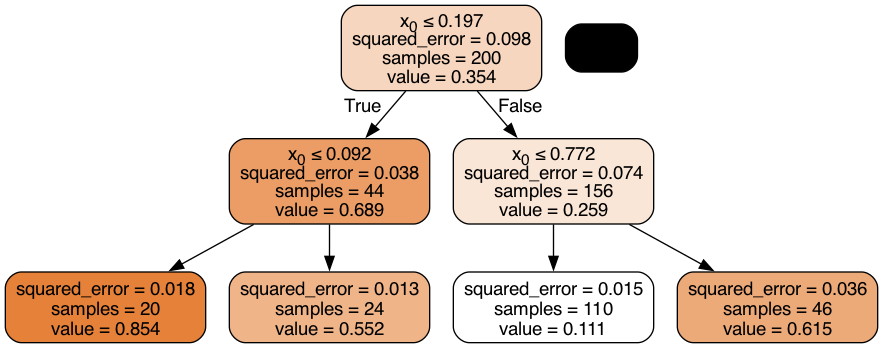

In [26]:
# display the tree
dot_data = StringIO()

export_graphviz(tree_reg, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
               )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

This tree looks very similar to the classification tree you built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose you want to make a prediction for a new instance with $x_1 = 0.6$. You traverse the tree starting at the root, and you eventually reach the leaf node that predicts value=0.1106. This prediction is simply the average target value of the 110 training instances associated to this leaf node. This prediction results in a Mean Squared Error (MSE) equal to 0.0151 over these 110 instances.

This model’s predictions are represented on the left of the next figure. If you set `max_depth=3`, you get the predictions represented on the right. Notice how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

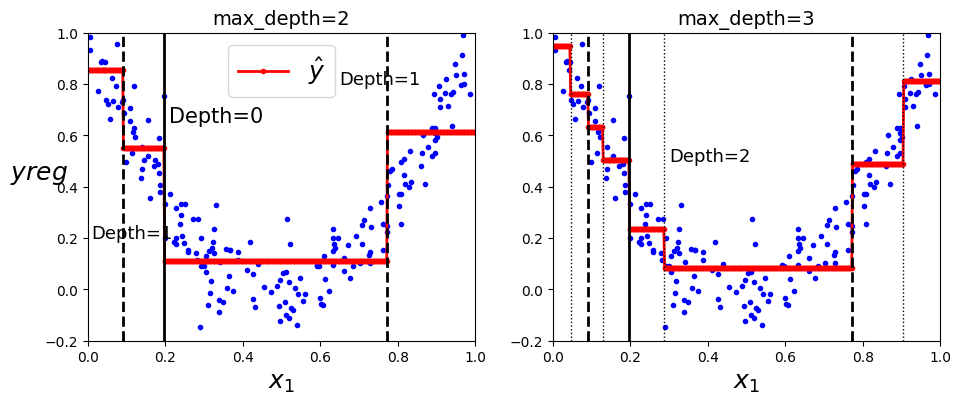

In [27]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(Xreg, yreg)
tree_reg2.fit(Xreg, yreg)

def plot_regression_predictions(tree_reg, Xreg, yreg, axes=[0, 1, -0.2, 1], ylabel="$yreg$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(Xreg, yreg, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, Xreg, yreg)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, Xreg, yreg, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE. The following equation shows the cost function that the algorithm tries to minimize.

$$J(k,t_k) = \frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right}$$

where  $ \quad MSE_{node} = \sum_{i\in node} (\hat{y}_{node}-y^{(i)})^2 \quad$ and $\quad \hat{y}_{node} = \frac{1}{m_{node}}\sum_{i\in node} y^{(i)}$

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters), you get the predictions on the left of the next figure. It is obviously overfitting the training set very badly. Just setting `min_samples_leaf=10` results in a much more reasonable model, represented on the right of the next figure.

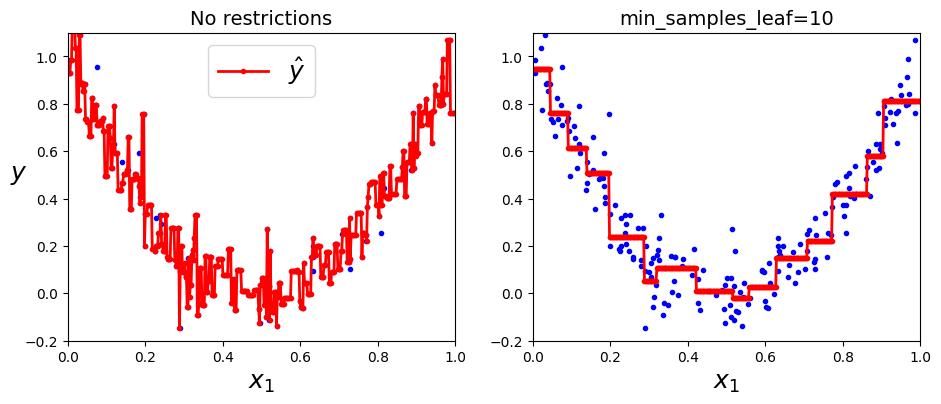

In [28]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(Xreg, yreg)
tree_reg2.fit(Xreg, yreg)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(Xreg, yreg, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(Xreg, yreg, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)


plt.show()

## 9. Instability

Hopefully by now you are convinced that Decision Trees have a lot going for them: they are simple to understand and interpret, easy to use, versatile, and powerful. However they do have a few limitations. First, as you may have noticed, Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation. 

For example, the following figure shows a simple linearly separable dataset: on the left, a Decision Tree can split it easily, while on the right, after the dataset is rotated by 45 degrees, the decision boundary looks unnecessarily convoluted. Although both Decision Trees fit the training set perfectly, it is very likely that the model on the right will not generalize well. One way to limit this problem is to use PCA, which often results in a better orientation of the training data.

In [29]:

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3]):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="round")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="triangle")
    plt.axis(axes)

    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
 


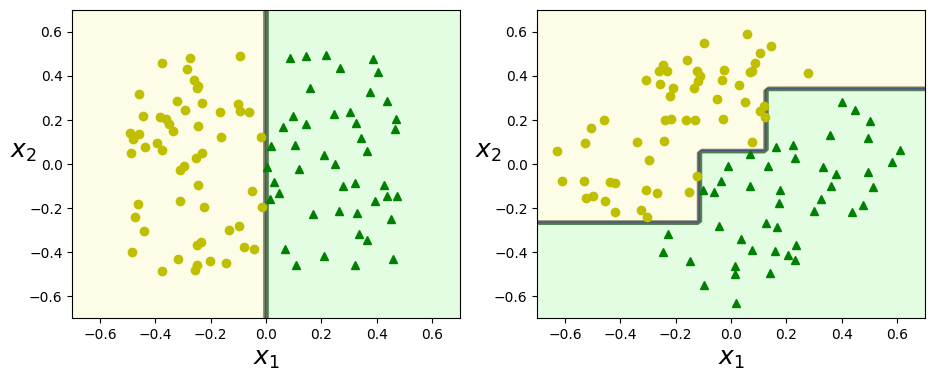

In [30]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7])
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7])

plt.show()

More generally, the main issue with Decision Trees is that they are very sensitive to small variations in the training data. 